# importing libraries

In [1]:
import os
import sys
import cv2 

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow import keras
import tensorflow.python.platform.build_info as build
import tensorflow.keras.backend as K
# from hrnet import seg_hrnet
# from hrnetmodel import build_hrnet
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPool2D,AveragePooling2D,Dropout,Activation,Input,concatenate,add,UpSampling2D
from tensorflow.keras.models import Model

# environment check

In [3]:
print("Python version        :",sys.version)
print("Tensorflow Gpu version:",tf.__version__)
print("keras version         :",keras.__version__)
print("GPUS Available        :",len(tf.config.experimental.list_physical_devices('GPU')))
print("Cudnn version         :",build.build_info['cudnn_version'])
print("Cuda version          :",build.build_info['cuda_version'])
# #print(tf.__version__)

Python version        : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensorflow Gpu version: 2.5.0
keras version         : 2.5.0
GPUS Available        : 1
Cudnn version         : 64_8
Cuda version          : 64_112


In [4]:
gpus=tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# setting the path to our files
data_path='CamVid'
train_img_path='CamVid/train'
train_msk_path="CamVid/train_labels"
val_img_path='CamVid/val'
val_msk_path="CamVid/val_labels"

In [6]:
labels = pd.read_csv(os.path.join(data_path ,'class_dict.csv'), index_col =0)#, index_col =0
labels

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


# viewing train images and masks

In [7]:
# reading the train images and masks
train_imgs=os.listdir(train_img_path)
train_msks=os.listdir(train_msk_path)
next_img = [os.path.join(train_img_path, fname)  for fname in train_imgs ]
next_msk = [os.path.join(train_msk_path, fname)  for fname in train_msks ]
val_imgs=os.listdir(val_img_path)

In [8]:
print("number of training data",len(train_imgs))
print("number of validation data",len(val_imgs))

number of training data 421
number of validation data 112


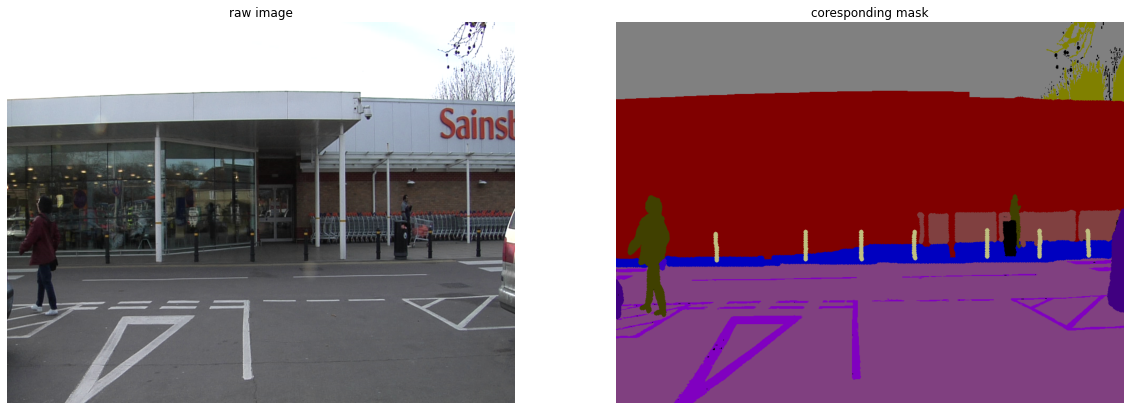

In [8]:
#choosing a random image and corresponding mask
ix=np.random.randint(0,len(train_imgs))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 20)
img = plt.imread(next_img[ix])
ax1.imshow(img)
ax1.set_title("raw image")
mask = plt.imread(next_msk[ix])
ax2.imshow(mask)
ax2.set_title("coresponding mask")
for ax in fig.get_axes():
    ax.axis('off')

In [9]:
# reading mask by cv2 then converting channels
mask=cv2.imread(next_msk[2])
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

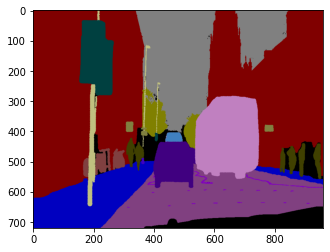

In [10]:
plt.imshow(mask);

In [11]:
label_names=[label for label in labels.index]
id2name={i:name for i,name in enumerate(labels.index)}
label_codes=[tuple(labels.loc[cl, :]) for cl in labels.index]
id2code={i:tuple(labels.loc[cl, :]) for i,cl in enumerate(labels.index)}

In [12]:
print("label_names  \n",label_names)

label_names  
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']


In [13]:
id2code

{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

# preprocessing images and corresponding masks

## Converting from rgb to one hot

In [14]:
def preprocess_mask(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 720 x 960 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id  {0:(r,g,b)}
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)  #(720,960,32)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image

## Converting from one hot to rgb

In [15]:
def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )   #(720,960,3)
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [16]:
mask_hot_encoded=preprocess_mask(mask, colormap = id2code)
msk_rgb=onehot_to_rgb(mask_hot_encoded)

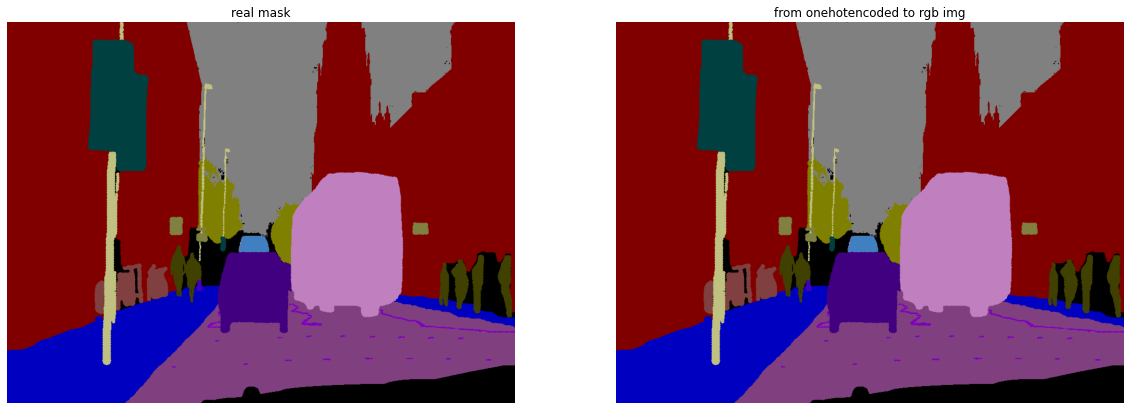

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 20)
#before converting to onehotencoded
ax1.imshow(mask)
ax1.set_title("real mask")

ax2.imshow(msk_rgb)
ax2.set_title("from onehotencoded to rgb img")
for ax in fig.get_axes():
    ax.axis('off')

# Training model 

## without data augmentation

### train generator

In [18]:
def trainGenerator(train_path,image_folder,mask_folder,aug_dict_img,aug_dict_msk,batch_size,image_color_mode = "rgb",
                    mask_color_mode = "rgb",target_size = (512,512),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
   
    '''
    image_datagen = ImageDataGenerator(**aug_dict_img)
    mask_datagen = ImageDataGenerator(**aug_dict_msk)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        mask_img=[preprocess_mask(mask[i]) for i in range(mask.shape[0])]
        yield(img,np.array(mask_img))

In [102]:
# setting the input arguments
train_path="CamVid"
image_folder="train"
mask_folder="train_labels"
batch_size=1
seed=1
data_gen_args = dict(rescale=1./255)

# So our usage here is as data loader instead of loading everything in RAM, not data augmentation
mask_gen_args = dict()

In [103]:
#!pip install SciPy

In [104]:
data_generator_train=trainGenerator(train_path,image_folder,mask_folder,data_gen_args,mask_gen_args,batch_size)
for img_batch,label_batch in data_generator_train:
    print(img_batch.shape)
    print(label_batch.shape)
    break  

Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.
(1, 512, 512, 3)
(1, 512, 512, 32)


### validation generator

In [105]:
def validationGenerator(val_path,image_folder,mask_folder,aug_dict_img,aug_dict_msk,batch_size,image_color_mode = "rgb",
                    mask_color_mode = "rgb",target_size = (512,512),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
   
    '''
    image_datagen = ImageDataGenerator(**aug_dict_img)
    mask_datagen = ImageDataGenerator(**aug_dict_msk)
    image_generator = image_datagen.flow_from_directory(
        val_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        mask_img=[preprocess_mask(mask[i]) for i in range(mask.shape[0])]
        yield(img,np.array(mask_img))

In [106]:
# setting the input arguments
val_path="CamVid"
image_folder="val"
mask_folder="val_labels"
batch_size=2
seed=1
data_gen_args = dict(rescale=1./255)
# So our usage here is as data loader instead of loading everything in RAM, not data augmentation
mask_gen_args = dict()

In [107]:
data_generator_valid=validationGenerator(val_path,image_folder,mask_folder,data_gen_args,mask_gen_args,batch_size)
for img_batch,label_batch in data_generator_valid:
    print(img_batch.shape)
    print(label_batch.shape)
    break  

Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
(2, 512, 512, 3)
(2, 512, 512, 32)


## compiling and training model

In [108]:
# model=seg_hrnet( 512, 512, 3, 32)
# model.summary()

# model hrnet

In [109]:
def resolution_block(input_layer,n_convs,filters,kernel_size,padding = 'same',kernel_initializer = 'glorot_uniform',activ_relu=True,
                     batch_norm = True,dropout = None,activation = 'relu'):
    '''
    Create a fully convolutional block with parameters
    inputs :
        n_convs : number of convolutional layers
        
    outputs:
        convs : 
    '''
    x = input_layer
    for i in range(n_convs):
        x = Conv2D(filters= filters,
                   kernel_size = kernel_size ,
                   padding=padding,
                   kernel_initializer=kernel_initializer )(x)
        if batch_norm :
           x = BatchNormalization()(x)
        if activ_relu :
           x = Activation('relu')(x)  
    if dropout : 
        x = Dropout(dropout)(x)
            
    
    return x

In [110]:
#down sampling for high resolution convolution /medium /low
def downsample_layer(input_layer,filters,kernel_size=3,strides=(2,2),batch_norm=False,activ_relu=False):
  #downsampled_layers[resolution]["downsample_1"]
  out=Conv2D(filters= filters,
            kernel_size = kernel_size ,strides=strides,
            padding='same',use_bias=False)(input_layer)
  if batch_norm :
           out = BatchNormalization()(out)
  if activ_relu :
           out = Activation('relu')(out)  
  return out

In [111]:
def transition_up_fuse(layer1,layer2,filters,target_size=0,batch_norm = True,activation_fun = False):
    
    size = layer1.shape[1]
    #print(size)
    ratio = target_size/size
    layer1 = UpSampling2D(size = int(ratio))(layer1)
    layer1  = Conv2D(filters=filters,kernel_size=(1,1))(layer1)
    if batch_norm :
        layer1 = BatchNormalization()(layer1)
    output=add([layer1,layer2])
    if activation_fun:
              output=Activation('relu')(output)
    #x = Activation(activation)(x)
    
    return output


In [112]:
def upscale(layer,filters,target_size=0,batch_norm = True,activation_fun = False):
    
    size = layer.shape[1]
    ratio = target_size/size
    layer = UpSampling2D(size = int(ratio))(layer)
    layer  = Conv2D(filters=filters,kernel_size=(1,1))(layer)
    if batch_norm :
        layer = BatchNormalization()(layer)
    if activation_fun:
          layer=Activation('relu')(layer)
    return layer

In [113]:
def add_layer(layers,activation_fun=True):
   '''
   this function adds two layers must be of same shape e.g(256,256,32)&(256,256,32)
   '''
   output=add(layers)
   if activation_fun:
              output=Activation('relu')(output)
   return output

In [114]:
def block_1(input_layer):
    out=resolution_block(input_layer,2,64,3)
    out=resolution_block(out,1,256,3,activ_relu=False)
    return out
    

In [115]:
def first_block(input_layer):
    x=downsample_layer(input_layer,64,batch_norm=True,activ_relu=True)
    out1=block_1(x)
    out2=resolution_block(x,1,256,3,activ_relu=False)

    out3=add_layer([out1,out2])
    out4=block_1(out3)
    out5=add_layer([out3,out4])
    out6=block_1(out5)
    out7=add_layer([out6,out5])
    out8=block_1(out7)
    out=add_layer([out8,out7])
    return out

In [116]:
def block2_1(input_layer):
    out=resolution_block(input_layer,1,32,3)
    out=resolution_block(out,1,32,3,activ_relu=False)  #conv>bn>act>con>bn
    return out

In [117]:
def block2_2(input_layer,filters=64):
    out=resolution_block(input_layer,1,filters,3)
    out=resolution_block(out,1,filters,3,activ_relu=False)
    return out

In [118]:
def block_h(input_layer):
    #hbtdy b high resolution
    outh1=resolution_block(input_layer,1,32,3)
    outh2=block2_1(outh1)
    outh3=add_layer([outh1,outh2])
    outh4=block2_1(outh3)
    outh5=add_layer([outh3,outh4])
    outh6=block2_1(outh5)
    outh7=add_layer([outh5,outh6])
    outh8=block2_1(outh7)
    out=add_layer([outh7,outh8])
    
    return out

In [119]:
def block_m_l(input_layer,filters,downsample=True):
    #hbtdy b medium resolution
    if downsample:
          input_layer=downsample_layer(input_layer,64,kernel_size=3,strides=(2,2),batch_norm=True,activ_relu=True)
    outm2=block2_2(input_layer,filters)
    outm3=add_layer([input_layer,outm2])
    outm4=block2_2(outm3,filters)
    outm5=add_layer([outm3,outm4])
    outm6=block2_2(outm5,filters)
    outm7=add_layer([outm5,outm6])
    outm8=block2_2(outm7,filters)
    out=add_layer([outm7,outm8])
    
    return out

In [120]:
def build_hrnet(height, width, channel):
    input_=Input(shape=(height, width, channel))
  #building first bock
    out_1=first_block(input_)
  # building second block high resolution
    out_2=block_h(out_1)   #(256,256,32)
    # building second block medium
    out_3=block_m_l(out_1,64)    #(128,128,64)
    out=[out_2,out_3]
    #building third block high
    out_4=transition_up_fuse(out_3,out_2,32,target_size=256,batch_norm=True)  #(256,256,32)
    out_5=block_h(out_4)   #(256,256,32)
    # building third block medium
    out_6=downsample_layer(out_4,64,batch_norm=True)  #(128,128,64)
  # adding the output from medium and downsampled high resolution
    medium_added=[out_3,out_6]
    out_7=add_layer(medium_added,activation_fun=False)  #(128,128,64)
    out_8=block_m_l(out_7,64,downsample=False)  #(128,128,64)
    ##defining third block low
    out_9=downsample_layer(out_7,128,batch_norm=True,activ_relu=True)  #(64,64,128)
    
    out_10=block_m_l(out_9,128,downsample=False)  #(64,64,128)
  #   #defining fourth block high resolution
  #   ## upsampling from low resolution(64,64,128)
    out_11=upscale(out_10,32,target_size=256,batch_norm = True,activation_fun = False) #256,256,32
    ## upscaling from medim (128,128,64)
    out_12=upscale(out_8,32,target_size=256,batch_norm = True,activation_fun = False) #256,256,32
    # add layer from high ,medium low
    out_13=add_layer([out_11,out_12,out_5],activation_fun=False)  #256,256,32
    out_14= block_h(out_13)     #(256,256,32)
    ###### fourth block medium resolution
    # down sampling high
    out_15=downsample_layer(out_5,64,batch_norm=True) #(128,128,64)
    #upsampling low resoltion
    out_16=upscale(out_10,64,target_size=128,batch_norm = True,activation_fun = False) #(128,128,64)
    ## adding down sampled ,upsampled ,medium resolution
    out_17=add_layer([out_15,out_16,out_8],activation_fun=False)  #128,128,64
    #building convs of medium
    out_18=block_m_l(out_17,64,downsample=False)   #128,128,64
    #### builing low resolution of fourth block
    #downsampling high resolution
    out_19=downsample_layer(out_5,128,strides=(4,4),batch_norm=True)  #64,64,128
    #downsampling medium
    out_20=downsample_layer(out_8,128,batch_norm=True)  #64,64,128
    out_21=add_layer([out_19,out_20,out_10],activation_fun=False) #64,64,128
  #building convc of low resolution
    out_4_low=block_m_l(out_21,128,downsample=False)  #64,64,128
    ###building very low resolution of fourth block
    out_4_vlow_0=downsample_layer(out_10,256,batch_norm=True) #32,32,256
    # # downsampling from medium resolution
    out_4_vlow_1=downsample_layer(out_8,256,strides=(4,4),batch_norm=True) #32,32,256
    #  # downsampling from high resolution
    out_4_vlow_2=downsample_layer(out_5,256,strides=(8,8),batch_norm=True) #32,32,256
    # #adding layers
    out_4_vlow=add_layer([out_4_vlow_0,out_4_vlow_1,out_4_vlow_2],activation_fun=False) 
    # # building convs of very low
    out_4_verylow_f=block_m_l(out_4_vlow,256,downsample=False) #32,32,256
    ## upscaling medium low verylow
    #upscaling very low
    output_1=upscale(out_4_verylow_f,32,target_size=256,batch_norm = True,activation_fun = False)  #vlow
    output_2=upscale(out_4_low,32,target_size=256,batch_norm = True,activation_fun = False)  #low
    output_3=upscale(out_18,32,target_size=256,batch_norm = True,activation_fun = False)   #medium
    out_f=concatenate([output_1, output_2,output_3,out_14], axis=-1)
   # out=[out_5,out_8,out_10,out_11,out_12,out_13,out_14,out_15,out_16,out_17,out_18,out_19,out_20,out_21,out_4]
    final_out=upscale(out_f,filters=32,target_size=512,batch_norm = True,activation_fun = False)
    output_class = Activation('softmax', name='Classification')(final_out)
    model=Model(inputs=input_,outputs=output_class)
    
    return  model

In [121]:
model=build_hrnet(512,512,3)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_318 (Conv2D)             (None, 256, 256, 64) 1728        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_318 (BatchN (None, 256, 256, 64) 256         conv2d_318[0][0]                 
__________________________________________________________________________________________________
activation_270 (Activation)     (None, 256, 256, 64) 0           batch_normalization_318[0][0]    
____________________________________________________________________________________________

In [122]:

mc = ModelCheckpoint(mode='max', filepath='hrnet.hdf5', monitor='val_accuracy', save_best_only='True', verbose=1)  #, save_weights_only='True'
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
callbacks = [mc, es]
steps_per_epoch,validation_steps=np.ceil(len(train_imgs)/4),np.ceil(len(val_imgs)/4)
print("steps per epoch",steps_per_epoch)
print("validation steps",validation_steps)

steps per epoch 106.0
validation steps 28.0


In [123]:
validation_steps

28.0

In [124]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [125]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4) ,loss = 'categorical_crossentropy',metrics= [dice_coef,'accuracy'])

In [127]:
#chk = ModelCheckpoint('unet_20.hdf5',monitor='val_loss',save_best_only=True,verbose=1)
history = model.fit_generator(data_generator_train,
                    validation_data=data_generator_valid,
                    steps_per_epoch=150,
                    validation_steps=50,
                    epochs=70,
                    callbacks=callbacks)

Epoch 1/70
150/150 [==============================] - 76s 510ms/step - loss: 2.1568 - dice_coef: 0.3182 - accuracy: 0.6395 - val_loss: 2.9826 - val_dice_coef: 0.1732 - val_accuracy: 0.2835

Epoch 00001: val_accuracy improved from 0.27982 to 0.28355, saving model to hrnet.hdf5
Epoch 2/70
150/150 [==============================] - 74s 493ms/step - loss: 1.9826 - dice_coef: 0.3642 - accuracy: 0.6874 - val_loss: 2.6597 - val_dice_coef: 0.2334 - val_accuracy: 0.4490

Epoch 00002: val_accuracy improved from 0.28355 to 0.44901, saving model to hrnet.hdf5
Epoch 3/70
150/150 [==============================] - 71s 473ms/step - loss: 1.8773 - dice_coef: 0.3905 - accuracy: 0.7239 - val_loss: 2.0913 - val_dice_coef: 0.3254 - val_accuracy: 0.6338

Epoch 00003: val_accuracy improved from 0.44901 to 0.63378, saving model to hrnet.hdf5
Epoch 4/70
150/150 [==============================] - 70s 470ms/step - loss: 1.8057 - dice_coef: 0.4104 - accuracy: 0.7454 - val_loss: 1.9111 - val_dice_coef: 0.3900 - v

150/150 [==============================] - 82s 552ms/step - loss: 0.8425 - dice_coef: 0.7616 - accuracy: 0.9031 - val_loss: 1.1098 - val_dice_coef: 0.7002 - val_accuracy: 0.7941

Epoch 00033: val_accuracy did not improve from 0.80477
Epoch 34/70
150/150 [==============================] - 62s 411ms/step - loss: 0.8350 - dice_coef: 0.7636 - accuracy: 0.9049 - val_loss: 1.2804 - val_dice_coef: 0.6492 - val_accuracy: 0.7447

Epoch 00034: val_accuracy did not improve from 0.80477
Epoch 35/70
150/150 [==============================] - 61s 411ms/step - loss: 0.8311 - dice_coef: 0.7663 - accuracy: 0.9027 - val_loss: 1.3238 - val_dice_coef: 0.6472 - val_accuracy: 0.7245

Epoch 00035: val_accuracy did not improve from 0.80477
Epoch 36/70
150/150 [==============================] - 61s 410ms/step - loss: 0.7906 - dice_coef: 0.7823 - accuracy: 0.9093 - val_loss: 1.0723 - val_dice_coef: 0.7177 - val_accuracy: 0.7976

Epoch 00036: val_accuracy did not improve from 0.80477
Epoch 37/70
150/150 [=======

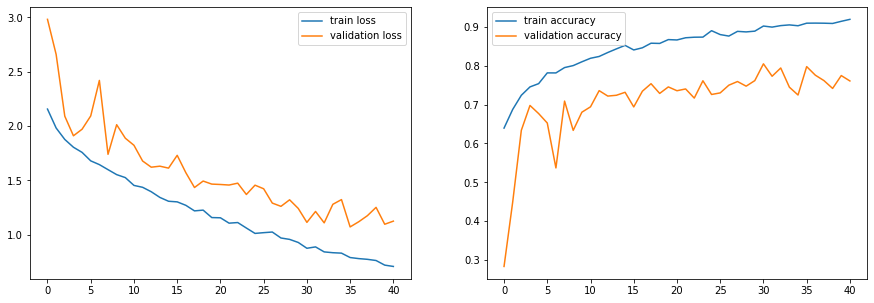

In [128]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train loss','validation loss'])
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['train accuracy','validation accuracy'])

### predicting and visualizing output

In [129]:
def predict_visualize(image_path,alpha = 0.7):
    '''
    Predicts image mask and make overlayed mask for visaualization
    inputs :
        image_path : path for image to be predicted
        alpha : alpha value for mask overlay
        
    returns :
        pred : predicted mask image of shape (256,256,32)
        
    '''
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(512,512),interpolation = cv2.INTER_AREA)
    
    pred = model.predict(np.expand_dims(image,0)/255)
    predicted_msk=onehot_to_rgb(pred[0], colormap = id2code)

    fig,ax = plt.subplots(1,2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    ax[0].imshow(image)
    ax[0].title.set_text('Image')
    ax[1].imshow(predicted_msk)
    ax[1].title.set_text('Predicted mask')
    for ax in fig.get_axes():
        ax.axis('off')

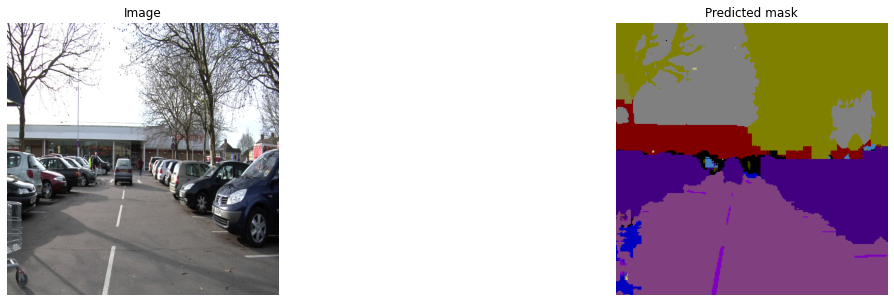

In [130]:
predict_visualize("CamVid\\test\\0006R0_f02520.png",alpha = 0.4)

In [ ]:
predict_visualize("CamVid\\test\\0006R0_f02520.png",alpha = 0.4)